<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumSubjectsClassifier_11_Spacy_Textcat_First3Pages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [4]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [5]:

texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 3 pages because of memory constraints
    if len(pages) > 3:
      pages = pages[:3]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [6]:
 del file_to_pages

In [7]:
df_annotations = df_annotations[~df_annotations.num_subjects.isna()]

In [8]:
df_annotations["num_subjects"].value_counts()

20.0      198
10.0      179
24.0      174
30.0      174
12.0      160
         ... 
1311.0      1
598.0       1
1300.0      1
2218.0      1
4891.0      1
Name: num_subjects, Length: 1444, dtype: int64

In [9]:
def get_num_subjects_clean(num):
    if pd.isna(num):
        return None
    if num >= 10000:
        return "10000+"
    if num >= 1000:
        return "1000+"
    if num >= 500:
        return "500+"
    if num >= 200:
        return "200+"
    if num >= 100:
        return "100+"
    if num >= 50:
        return "50+"
    if num >= 25:
        return "25+"
    return "1-24"
df_annotations["num_subjects_clean"] = df_annotations["num_subjects"].apply(get_num_subjects_clean)

In [10]:
df_annotations["num_subjects_clean"].value_counts()

1-24      2980
25+       2119
50+       2016
100+      1674
200+      1656
500+       816
1000+      547
10000+     112
Name: num_subjects_clean, dtype: int64

In [19]:
labels = list(sorted(set(df_annotations["num_subjects_clean"]), key =lambda x : int(re.sub(r'\D.*', '', x))))
labels

['1-24', '25+', '50+', '100+', '200+', '500+', '1000+', '10000+']

In [12]:
import spacy
nlp = spacy.blank("en")
from spacy.tokens import DocBin

docs_train = []
for i in range(10):
  docs_train.append(DocBin())
docs_val = DocBin()

for idx in range(len(df_annotations)):
  if idx % 100 == 0:
    print (idx, len(df_annotations))
  if df_annotations.train_val.iloc[idx] == "train":
    docs_list = docs_train[idx % 10]
  else:
    docs_list = docs_val
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]
  doc = nlp(text)

  cats = {}
  for a in labels:
      cats[a] = 0
  if pd.isna(df_annotations.num_subjects_clean.iloc[idx]):
    continue
  cats[df_annotations.num_subjects_clean.iloc[idx]] = 1
  doc.cats = cats

  aug = 1
  # upsample
  if df_annotations.train_val.iloc[idx] == "train" and df_annotations.num_subjects_clean.iloc[idx] in ("500+", "1000+", "10000+"):
    aug = 2
  for i in range(aug):
    docs_list.add(doc)

KeyboardInterrupt: ignored

In [ ]:
!mkdir train.spacy
!mkdir /content/drive/MyDrive/data/subjects_11_train.spacy


In [ ]:
for idx, doc_bin_train in enumerate(docs_train):
  doc_bin_train.to_disk(f"train.spacy/train_doc_bin{idx}.spacy")
  doc_bin_train.to_disk(f"/content/drive/MyDrive/data/subjects_11_train.spacy/train_doc_bin{idx}.spacy")

In [ ]:
docs_val.to_disk("dev.spacy")

In [ ]:
docs_val.to_disk("/content/drive/MyDrive/data/subjects_11_dev.spacy")

In [15]:
!python -m spacy train ./spacy_textcat_is_international_11.cfg --output /content/drive/MyDrive/data/output_subjects_11 --paths.train /content/drive/MyDrive/data/subjects_11_train.spacy --paths.dev  /content/drive/MyDrive/data/subjects_11_dev.spacy --gpu-id 0

ℹ Saving to output directory:
/content/drive/MyDrive/data/output_subjects_11
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-11-17 15:23:03,874] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-17 15:23:03,884] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-17 15:23:03,888] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-17 15:23:03,889] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
[2022-11-17 15:25:51,158] [INFO] Initialized pipeline components: ['textcat']
INFO:spacy:Initialized pipeline components: ['textcat']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.0
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.11        0.00    0.00
  0     200         2

In [11]:
import spacy
nlp = spacy.load("/content/drive/MyDrive/data/output_subjects_11/model-best")

In [12]:
df_val = df_annotations[df_annotations.train_val=="val"]

predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [13]:
# pred_proba = []
# for idx in range(len(df_val)):
#     pred_proba.append([predictions[idx][a] for a in range(num_classes)])

In [14]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [15]:
df_val["y_pred"] = [max(p, key=p.get) for p in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
num_subjects_ground_truths = df_val.num_subjects_clean
pred_num_subjects = df_val["y_pred"]

In [17]:
acc = accuracy_score(num_subjects_ground_truths, pred_num_subjects)
print (f"Num subjects accuracy {acc}")

Num subjects accuracy 0.29308755760368665


''

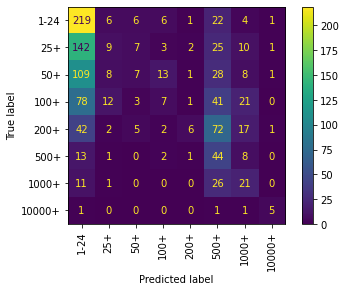

In [20]:
ConfusionMatrixDisplay.from_predictions(num_subjects_ground_truths, pred_num_subjects, labels=labels)
plt.xticks(rotation=90)
;

In [21]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for i in labels:
  roc_auc = roc_auc_score(num_subjects_ground_truths == i, [p[i] for p in predictions])
  print (f"Num arms ROC AUC {roc_auc} for {i} subjects")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

Num arms ROC AUC 0.7290819144040497 for 1-24 subjects
Num arms ROC AUC 0.595534103928219 for 25+ subjects
Num arms ROC AUC 0.5509858712715855 for 50+ subjects
Num arms ROC AUC 0.5852075376282555 for 100+ subjects
Num arms ROC AUC 0.7059781268584192 for 200+ subjects
Num arms ROC AUC 0.7710116398493667 for 500+ subjects
Num arms ROC AUC 0.7659827534939043 for 1000+ subjects
Num arms ROC AUC 0.8789461467038069 for 10000+ subjects
Average 0.6978410117672009


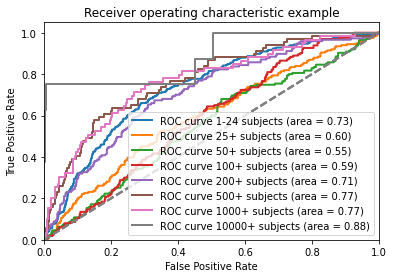

In [22]:
plt.figure()
lw = 2
    
for i in labels:
    fpr, tpr, _ = roc_curve(num_subjects_ground_truths == i, [p[i] for p in predictions])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve {i} subjects (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()